In [2]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os
import random

import torch

from utils import *

In [3]:
def reproducibility(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
reproducibility(3)

In [4]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA TITAN RTX


In [5]:
def args_create():
    # @title Arguments
    parser = argparse.ArgumentParser(description='Actor Critic')

    parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
    parser.add_argument('--episodes', default=19, type=int, metavar='N', help='Number of episodes for training agent.')
    parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
    parser.add_argument('--evaluate', default=True, type=bool, help='Evaluation or Not')


    # Env Properties
    parser.add_argument('--a_control_size', default=50, type=int, help='Attack Control group size')
    parser.add_argument('--b_control_size', default=50, type=int, help='Beacon Control group size')
    parser.add_argument('--gene_size', default=100, type=int, help='States gene size')
    parser.add_argument('--beacon_size', default=20, type=int, help='Beacon population size')
    parser.add_argument('--victim_prob', default=1, type=float, help='Victim inside beacon or not!')
    parser.add_argument('--max_queries', default=5, type=int, help='Maximum queries per episode')


    parser.add_argument('--attacker_type', default="optimal", choices=["random", "optimal", "agent"], type=str, help='Type of the attacker')
    parser.add_argument('--beacon_type', default="agent", choices=["random", "agent", "truth", "beacon_strategy"], type=str, help='Type of the beacon')

    parser.add_argument('--beacon_agent', default="td", choices=["td", "ppo"], type=str, help='Type of the beacon')

    parser.add_argument('--pop_reset_freq', default=100000000, type=int, help='Reset Population Frequency (Epochs)')
    parser.add_argument('--plot-freq', default=1, type=int, metavar='N', help='Plot Frequencies')

    # utils
    parser.add_argument('--resume', default=None, type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
    parser.add_argument('--results-dir', default='./results/simulation', type=str, metavar='PATH', help='path to cache (default: none)')

    # args = parser.parse_args()  # running in command line
    args = parser.parse_args('')  # running in ipynb

    args.results_dir = os.path.join(args.results_dir, "run"+str(len(os.listdir(args.results_dir))))
    os.makedirs(args.results_dir)
    os.makedirs(args.results_dir+"/logs")
    os.makedirs(args.results_dir+"/rewards")
    os.makedirs(args.results_dir+"/indrewards")
    os.makedirs(args.results_dir+"/actions")
    os.makedirs(args.results_dir+"/pvalues")

    args.device = device

    print(args)
    return args

# args = args_create()

In [6]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join("/mnt/kerem/CEU", "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join("/mnt/kerem/CEU", "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [7]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join("/mnt/kerem/CEU", "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

binary = binary.T
binary.shape #(164, 4029840)

(164, 4029840)

In [8]:
beacon.shape, reference.shape, binary.shape, maf_values.shape

((4029840, 164), (4029840, 1), (164, 4029840), (4029840,))

In [9]:
from ppo import PPO
from td import TD3
%load_ext autoreload
%autoreload 2

from env import Env

args=args_create()


def simulate(args, beacon_type, attacker_type, beacon_agent, attacker_resume, beacon_resume):
    args.beacon_type = beacon_type 
    args.attacker_type = attacker_type 
    args.beacon_agent = beacon_agent 
    env = Env(args, beacon, maf_values, binary)
    ################ PPO hyperparameters ################
    K_epochs = 300         # update policy for K epochs
    eps_clip = 0.1           # clip parameter for PPO
    gamma = 0.99                # discount factor

    lr_actor = 0.0001      # learning rate for actor network
    lr_critic = 0.0001        # learning rate for critic network

    i_episode = 0

    attacker_state_dim = 400
    attacker_action_dim = 10

    cumulative_rewards = []

    if attacker_type == "agent":
        attacker_agent = PPO(attacker_state_dim, attacker_action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
        attacker_agent.load(attacker_resume)

    if beacon_type == "agent":
        if beacon_agent == "ppo":
            state_dim = 9
            action_dim = 2
            beacon_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, None)
        
        elif beacon_agent == "td":
            state_dim = 9
            action_dim = 1
            beacon_agent = TD3(state_dim, action_dim, max_action=1)
        else:    
            raise NotImplemented
        beacon_agent.load(beacon_resume)

    if attacker_type == "agent" and beacon_type == "agent":
        while i_episode < args.episodes:
            s_reward = 0
            for t in range(1, args.max_queries+1):
                _, rewards, done, _  = env.step(attacker_agent=attacker_agent, beacon_agent=beacon_agent)
                s_reward += rewards[1]
                if done:
                    break
            cumulative_rewards.append(s_reward)
            print("Victim: {} \t Current Episode Reward : {}".format(env.victim_id, rewards[1]))
            env.reset()
            i_episode += 1


    elif attacker_type == "agent":
        while i_episode < args.episodes:
            s_reward = 0
            for t in range(1, args.max_queries+1):
                _, rewards, done, _  = env.step(attacker_agent=attacker_agent)
                s_reward += rewards[1]
                if done:
                    break
            cumulative_rewards.append(s_reward)
            print("Victim: {} \t Current Episode Reward : {}".format(env.victim_id, rewards[1]))
            env.reset()
            i_episode += 1

    elif beacon_type == "agent":
        while i_episode < args.episodes:
            s_reward = 0
            for t in range(1, args.max_queries+1):
                _, rewards, done, _  = env.step(beacon_agent=beacon_agent)
                s_reward += rewards[1]
                if done:
                    break
            cumulative_rewards.append(s_reward)
            print("Victim: {} \t Current Episode Reward : {}".format(env.victim_id, rewards[0]))
            env.reset()
            i_episode += 1

    else:
        while i_episode < args.episodes:
            s_reward = 0
            for t in range(1, args.max_queries+1):
                _, rewards, done, _  = env.step()
                s_reward += rewards[1]
                if done:
                    break

            cumulative_rewards.append(s_reward)
            print("Victim: {} \t Current Episode Reward : {}".format(env.victim_id, rewards[1]))
            env.reset()
            i_episode += 1
    
    print(cumulative_rewards)
    return cumulative_rewards

Device set to : NVIDIA TITAN RTX
Device set to : NVIDIA TITAN RTX
Namespace(data='/mnt/kerem/CEU', episodes=19, seed=3, evaluate=True, a_control_size=50, b_control_size=50, gene_size=100, beacon_size=20, victim_prob=1, max_queries=5, attacker_type='optimal', beacon_type='agent', beacon_agent='td', pop_reset_freq=100000000, plot_freq=1, resume=None, results_dir='./results/simulation/run60', device=device(type='cuda', index=0))


In [ ]:
beacon_type = "agent"
attacker_type = "optimal"
beacon_agent = "td"
beacon_resume = "/mnt/sobhan/Beacons/results/train/TD3 Beacon 7000/weights"
rewards_1 = simulate(args, beacon_type, attacker_type, beacon_agent, None, beacon_resume)


beacon_type = "agent"
attacker_type = "optimal"
beacon_agent = "td"
beacon_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights"
rewards_2 = simulate(args, beacon_type, attacker_type, beacon_agent, None, beacon_resume)

beacon_type = "truth"
attacker_type = "optimal"
rewards_3 = simulate(args, beacon_type, attacker_type, beacon_agent, None, beacon_resume)


beacon_type = "random"
attacker_type = "optimal"
rewards_4 = simulate(args, beacon_type, attacker_type, beacon_agent, None, beacon_resume)



In [ ]:
rewardss = [rewards_1, rewards_2, rewards_3, rewards_4]
labels = ["Trained Against\nOptimal Attacker", "Trained Against\nAttacker Agent(PPO)", "Truth", "Random"]
# Call the function with sample data
plot_comparisons(rewardss, labels)

In [10]:

beacon_type = "truth"
attacker_type = "agent"
attacker_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights/PPO_attacker0.pth"
rewards_6 = simulate(args, beacon_type, attacker_type, None, attacker_resume, None)


beacon_type = "truth"
attacker_type = "agent"
attacker_resume = "/mnt/sobhan/Beacons/agents/attacker1/PPO_0.pth"
rewards_7 = simulate(args, beacon_type, attacker_type, None, attacker_resume, None)

beacon_type = "truth"
attacker_type = "optimal"
rewards_8 = simulate(args, beacon_type, attacker_type, None, None, None)



beacon_type = "agent"
attacker_type = "agent"
attacker_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights/PPO_attacker0.pth"
beacon_agent = "td"
beacon_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights"
rewards_9 = simulate(args, beacon_type, attacker_type, beacon_agent=beacon_agent, attacker_resume=attacker_resume, beacon_resume=beacon_resume)


beacon_type = "agent"
attacker_type = "agent"
attacker_resume = "/mnt/sobhan/Beacons/agents/attacker1/PPO_0.pth"
beacon_agent = "td"
beacon_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights"
rewards_10 = simulate(args, beacon_type, attacker_type, beacon_agent=beacon_agent, attacker_resume=attacker_resume, beacon_resume=beacon_resume)

beacon_type = "agent"
attacker_type = "optimal"
beacon_agent = "td"
beacon_resume = "/mnt/sobhan/Beacons/results/train/Both PPO A TD3 B 7000/weights"
rewards_11 = simulate(args, beacon_type, attacker_type, beacon_agent=beacon_agent, attacker_resume=None, beacon_resume=beacon_resume)

./results/simulation/run60/logs/beacon_log.csv
./results/simulation/run60/logs/beacon_control_log.csv
./results/simulation/run60/logs/attacker_log.csv
./results/simulation/run60/logs/attacker_control_log.csv
==================================⬇️⬇️⬇️⬇️Episode: 1⬇️⬇️⬇️⬇️==============================
-------------------------


/mnt/sobhan/cpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------------------------------Actions---------------------------------
Attacker Action: Position 37 with MAF: 0.305 and SNP: 1.0 and LRT: -4.769712909080681e-07
Beacon Action: 1
aaaa tensor(1.4800)
--------------------------------Actions---------------------------------
Attacker Action: Position 86 with MAF: 0.075 and SNP: 1.0 and LRT: -0.04518121681044285
Beacon Action: 1
aaaa tensor(1.0800)
--------------------------------Actions---------------------------------
Attacker Action: Position 14 with MAF: 0.009 and SNP: 1.0 and LRT: -1.1917965947872293
Beacon Action: 1
⛔⛔⛔ Attacker Identified the VICTIM ⛔⛔⛔
⛔⛔⛔ Attacker Identified the VICTIM ⛔⛔⛔
aaaa tensor(-14.)
Victim: 0 	 Current Episode Reward : 40
==================================⬇️⬇️⬇️⬇️Episode: 2⬇️⬇️⬇️⬇️==============================
-------------------------
--------------------------------Actions---------------------------------
Attacker Action: Position 90 with MAF: 0.205 and SNP: 1.0 and LRT: -0.00010328088542799208
Beacon A

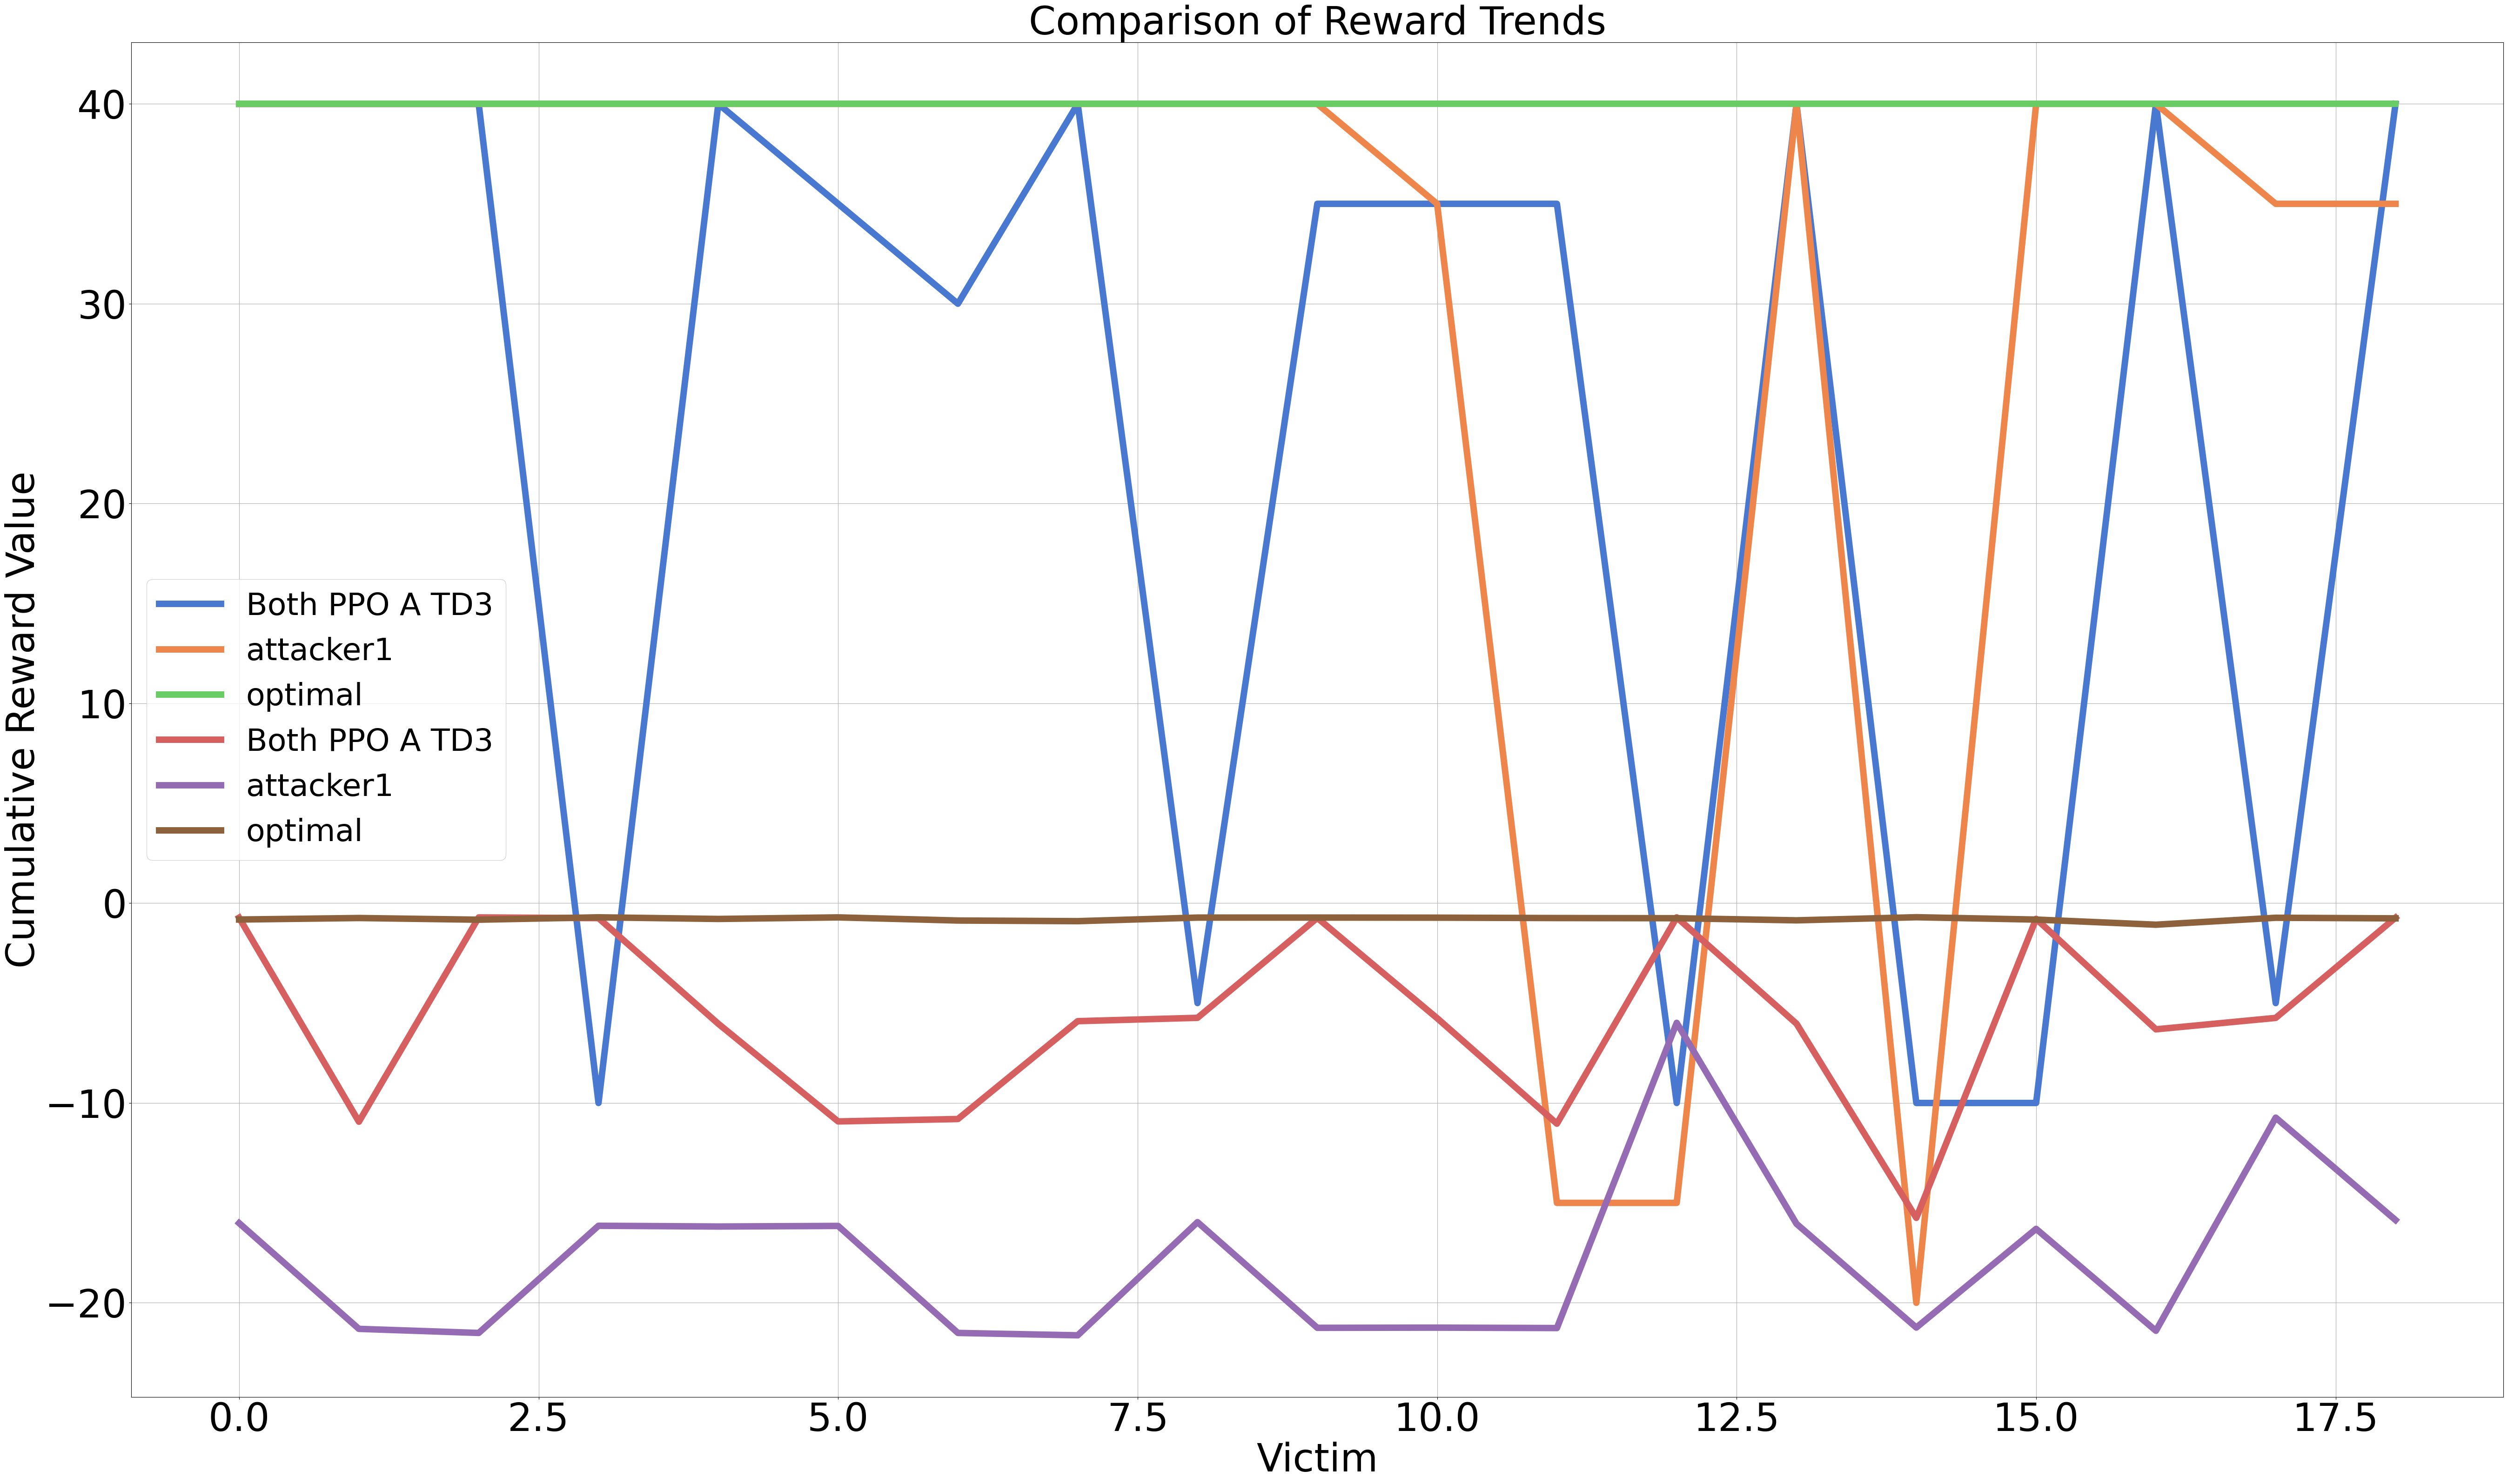

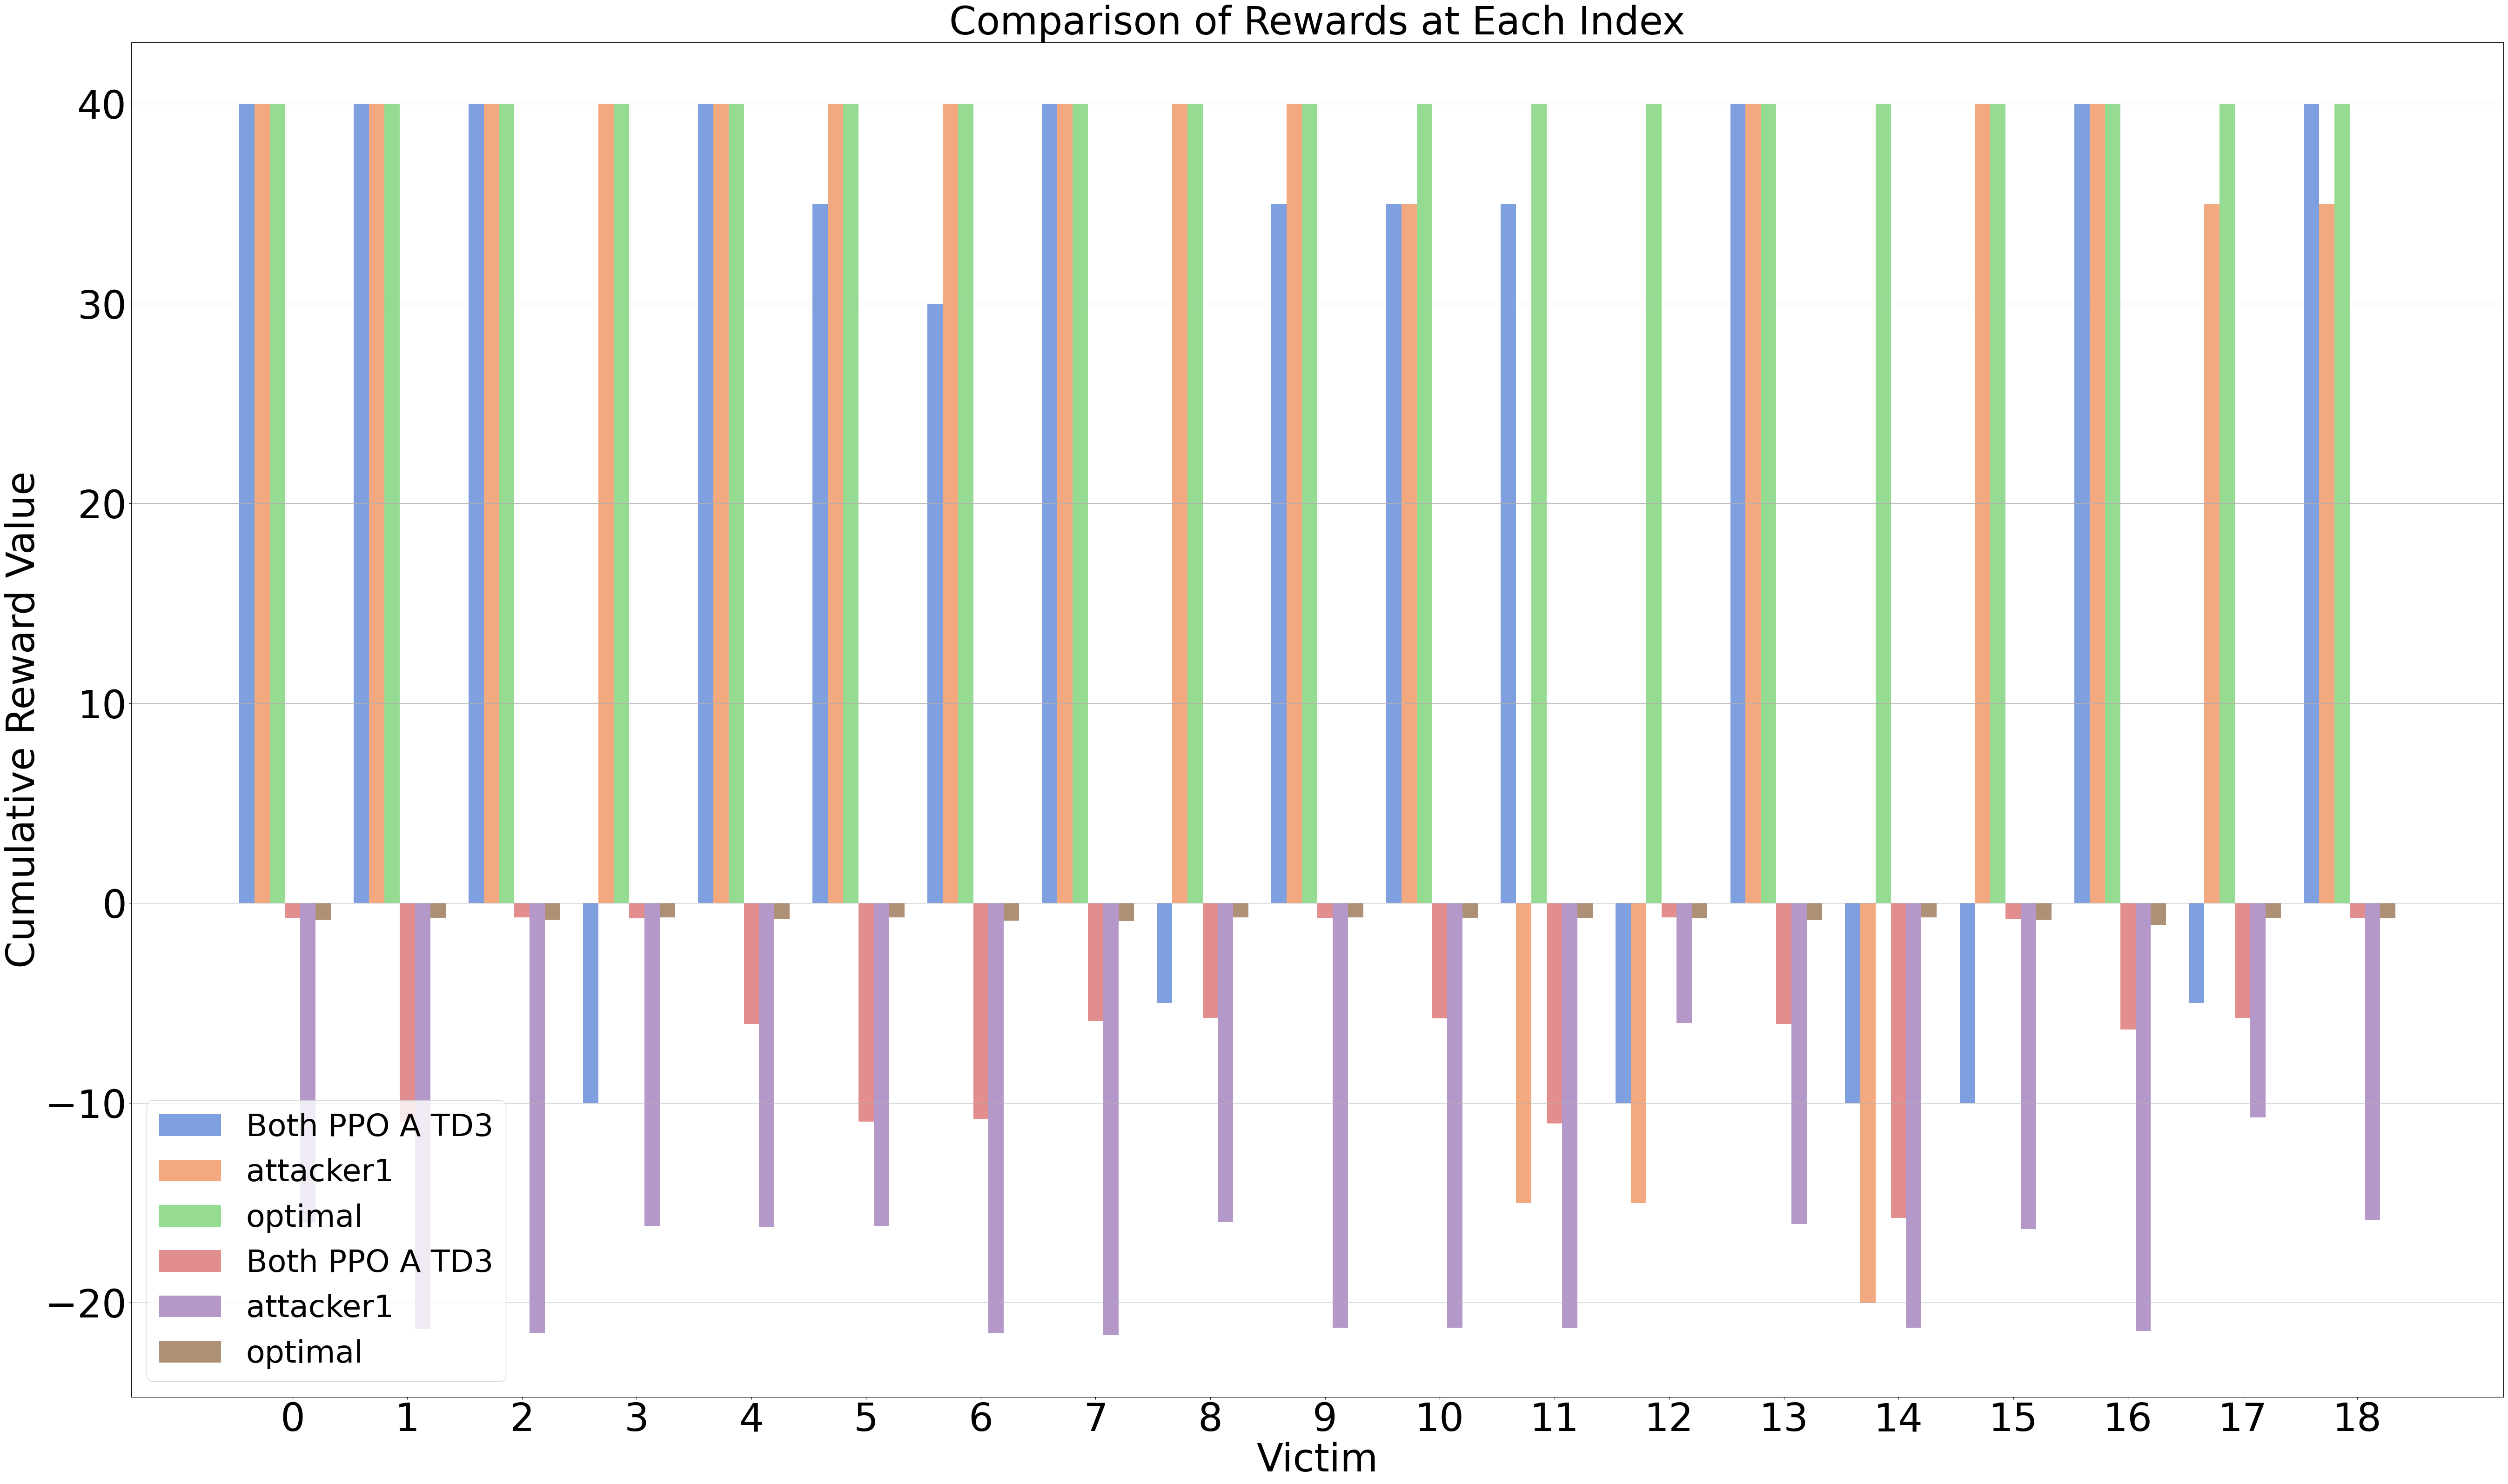

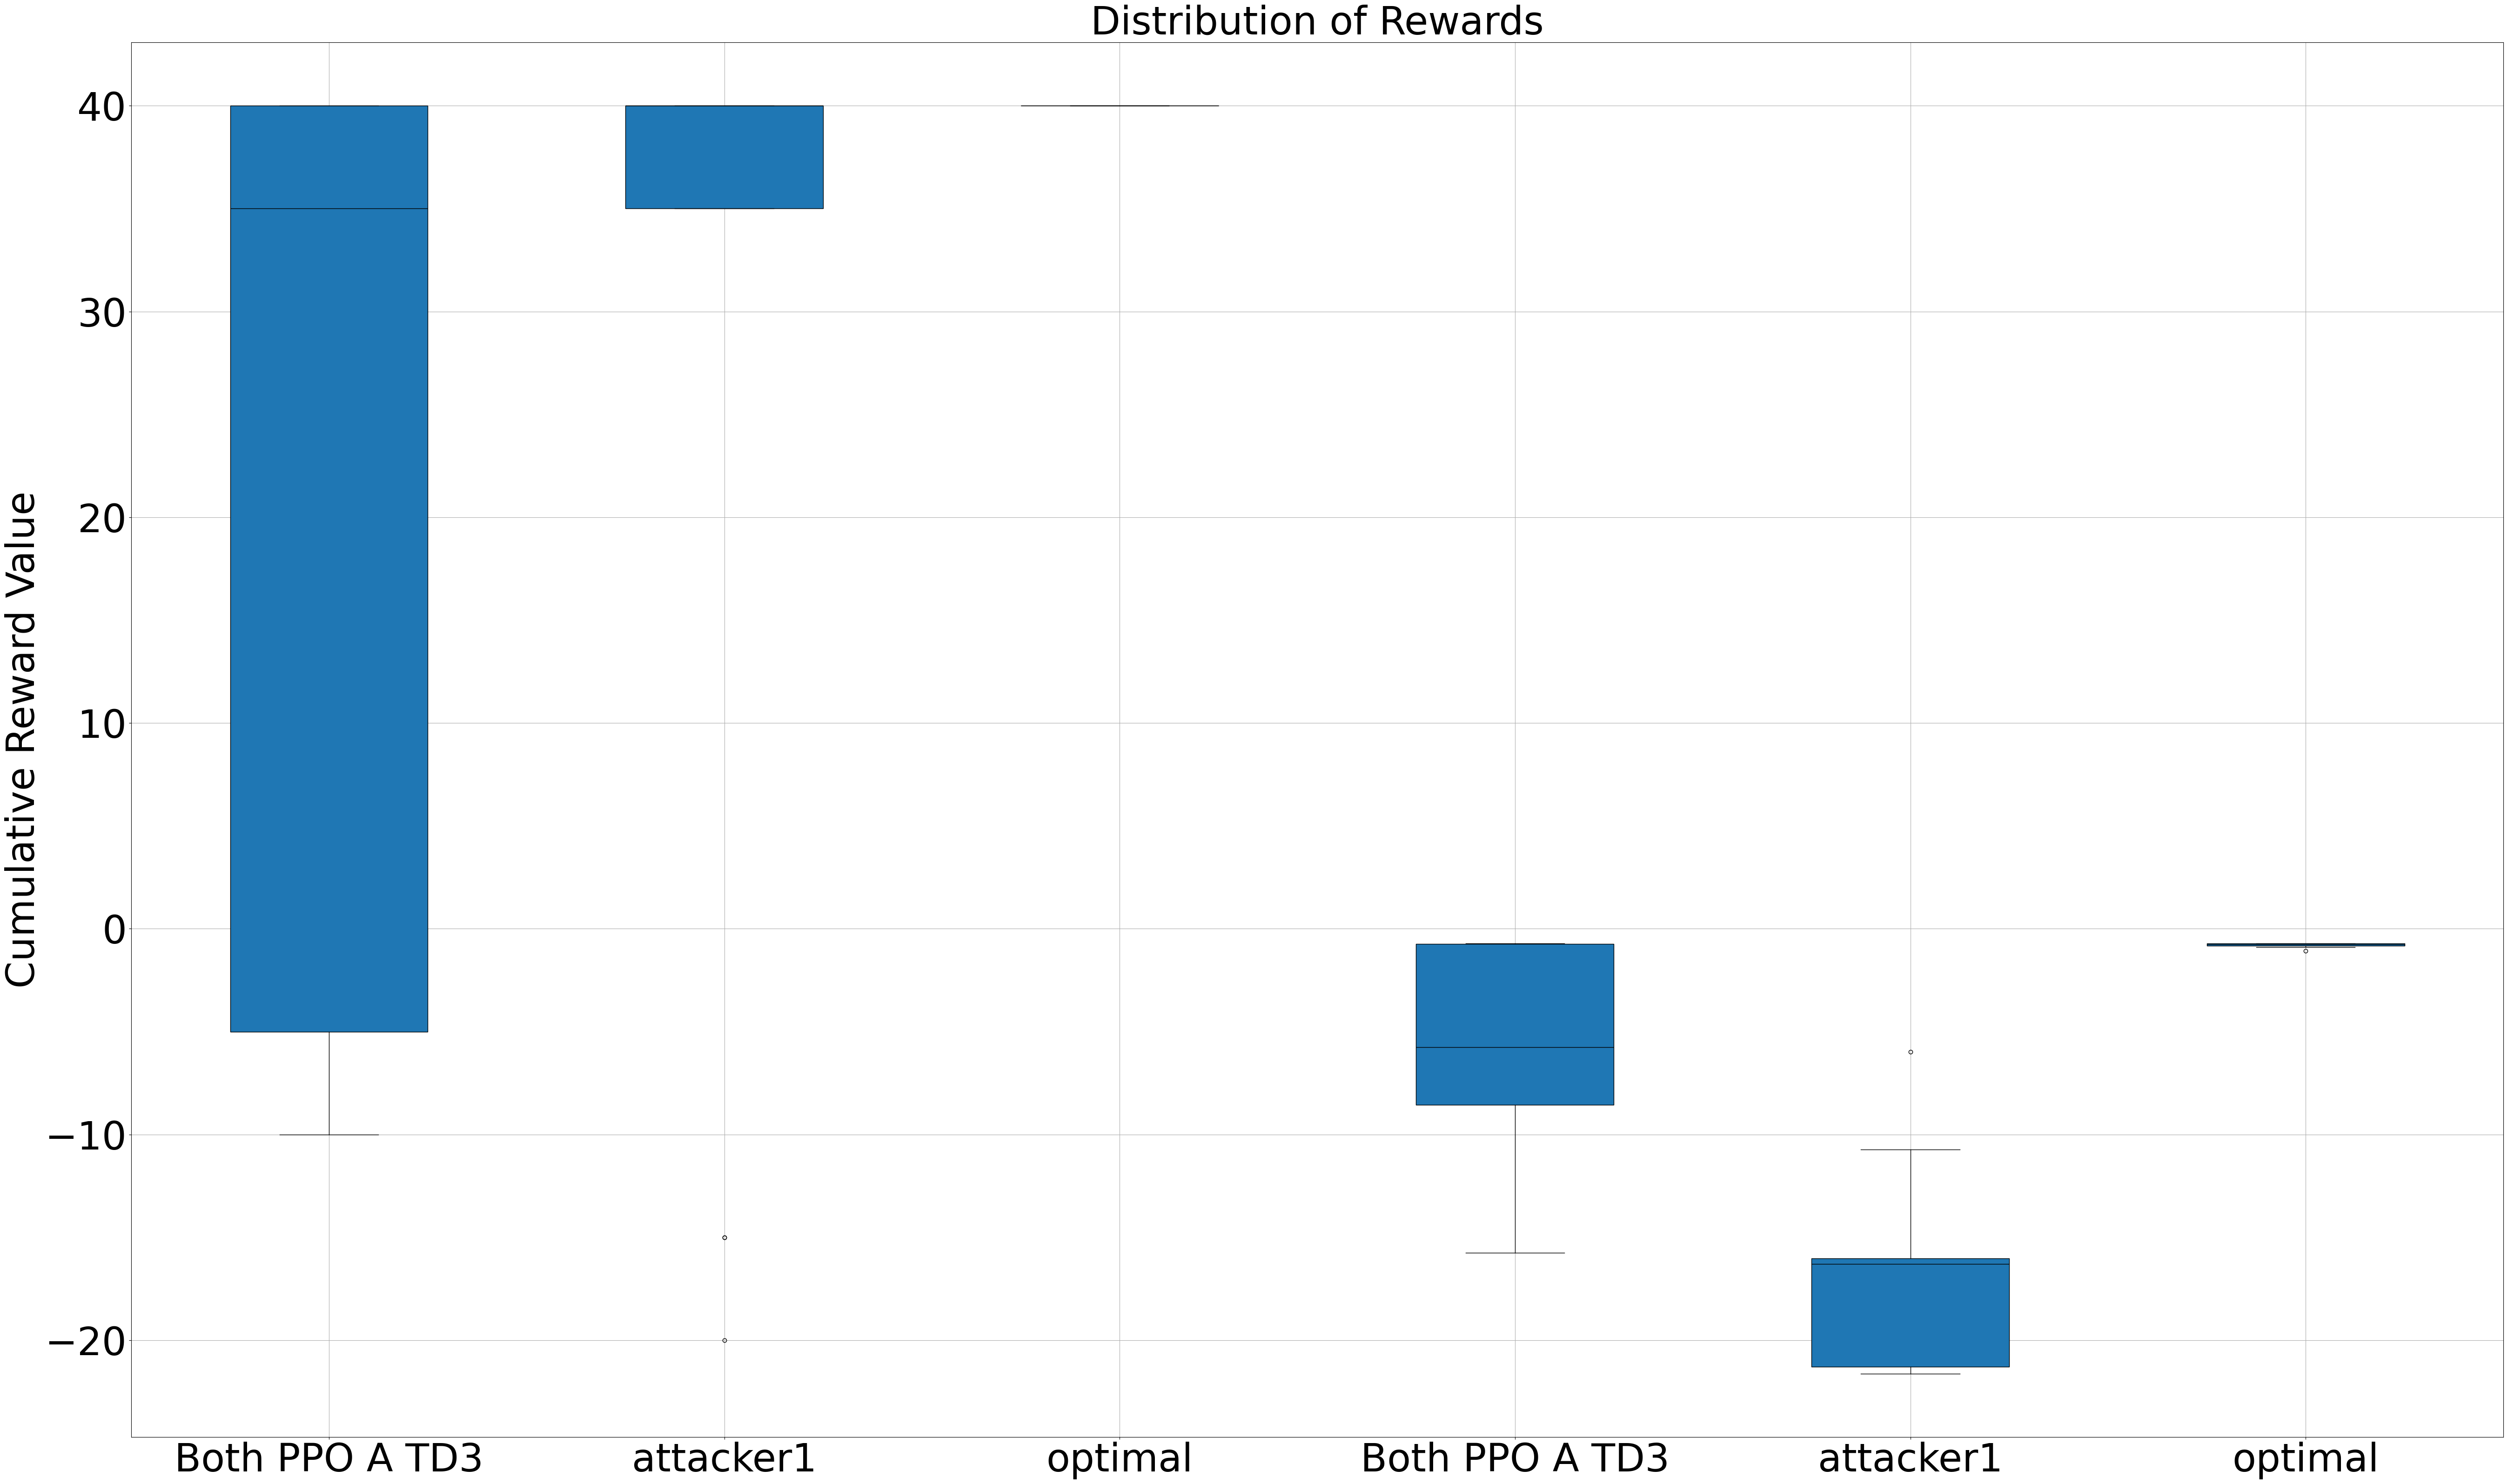

In [11]:
rewardss = [rewards_6, rewards_7, rewards_8, rewards_9, rewards_10, rewards_11]
labels = ["Both PPO A TD3", "attacker1", "optimal", "Both PPO A TD3", "attacker1", "optimal"]
# Call the function with sample data
plot_comparisons(rewardss, labels)

In [ ]:
    has_continuous_action_space = True                

action_std = 0.4             # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.0025       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.05                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)

################ PPO hyperparameters ################
K_epochs = 200          # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0      

In [ ]:
%load_ext autoreload
%autoreload 2

from ppo import PPO
from environment import BeaconEnv

args = args_create()

print("\n=============================================\n")
print("Start Simulation Using Optimal Attacker")

state_dim = 7
action_dim = env.action_space.shape[0]
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.load("/mnt/sobhan/Beaconsv2/results/train/run14/weights/PPO_1.pth")


env = BeaconEnv(args, beacon, maf_values, binary)
state = env.reset()[1]
total_reward = 0
current_ureward = 0
current_preward = 0
privacy_rewards = []
utility_rewards = []
total_rewards = []
lrt_values_list = []


done = False
while not done:
    # print("\n=============================================\n")

    # state = torch.flatten(state)
    with torch.no_grad():
        action, _, _ = ppo_agent.policy_old.act(torch.as_tensor(state).float().to(args.device))

    # print("Beacon Action: ", action)

    action = action.squeeze().item()
    state, reward, done, rewards = env.step([action])

    total_reward += reward
    current_preward += rewards[0]
    current_ureward += rewards[1]

    # print("Current Privacy Reward: {}\nCurrent Utility Reward: {}\nThis Episode Reward: {}\nTotal Reward: {}".format(rewards[0], rewards[1], reward, total_reward))
    total_rewards.append(total_reward)
    utility_rewards.append(current_ureward)
    privacy_rewards.append(current_preward)
    # lrt_values_list.append(lrt_values)

# plot_lists(utility_rewards, args.results_dir, 'utilities', 0)
print(f"Validation completed, total reward")
# print("\n=============================================\n")